# Compare deepcoadds and Objects

 work with Weakly_2022_44
- use jupyter kernel LSST
- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2023/12/23
- update : 2023/12/23


In [1]:
! eups list -s | grep LOCAL

analysis_tools        LOCAL:/home/d/dagoret/repos/repos_w_2023_44/analysis_tools 	setup
atmospec              LOCAL:/home/d/dagoret/repos/repos_w_2023_44/atmospec 	setup
eups                  LOCAL:/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/eups 	setup
spectractor           LOCAL:/home/d/dagoret/repos/repos_w_2023_44/Spectractor 	setup


In [2]:
! eups list -s lsst_distrib

   g4213664e8e+d053631def 	current w_2023_44 setup


In [3]:
import lsst.daf.butler as dafButler
import lsst.daf.base as dafBase

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [5]:
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.geom as geom
import pprint

In [6]:
#Set the matplotlib plot color table.
plt.style.use('tableau-colorblind10')

In [7]:
# Let us also set `lsst.afw.display` to use the `matplotlib` backend:
afwDisplay.setDefaultBackend('matplotlib')
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [8]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

## Config

### Butler repo and collection

In [9]:
#repo =  "/sdf/group/rubin/repo/main"
repo = "/sdf/group/rubin/repo/oga/"
butler = dafButler.Butler(repo)
registry = butler.registry

### Give the collection

In [10]:
my_collection = "LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553"

### input files

- object file
- tract and patch

In [11]:
file_obs = "objectTable_202312.csv"
file_tractpatch = "Latiss_tractspatchs.pickle"

### DataId

In [12]:
tract = 3863 
patch = 242
band = 'g'
skymap = 'latiss_v1'

In [13]:
the_dataId = {'skymap':skymap,'band': band, 'tract': tract, 'patch': patch}

In [14]:
the_title = f"Auxtel deepCoadd : band={band}, tract={tract}, patch={patch}" 

## Init

In [15]:
with open('Latiss_tractspatchs.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [16]:
tracts_patchs_dict

{5616: array([335, 355, 358, 336, 337, 338, 316, 357, 317, 356]),
 5634: array([ 91,  52,  93,  72,  92, 109, 110,  54,  71,  53,  55, 112, 111,
         74,  73,  90]),
 5615: array([332, 333, 312, 313, 295, 331, 276, 275, 294, 293, 314, 274]),
 10644: array([166, 184, 183, 201, 161, 180, 207, 188, 202, 182, 189, 208, 164,
        181, 185, 165, 203, 162]),
 383: array([359, 360]),
 8188: array([48, 65, 47, 28, 46, 66, 27]),
 3863: array([241, 243, 242, 260, 261, 222, 262, 224, 223]),
 455: array([52, 33, 51, 32, 14, 53, 34, 15, 13]),
 452: array([42, 44, 25, 24, 63, 23, 43, 62]),
 5839: array([9, 7, 8]),
 10643: array([171, 190]),
 382: array([343, 342])}

In [17]:
df = pd.read_csv(file_obs,index_col=0) 

In [18]:
selection1 =  (df["tract"] == tract) & (df["patch"] == patch)
selection2 = df["refExtendedness"] == False
selection3 = df["detect_isPrimary"] == True

In [19]:
df_sel = df[selection1 & selection2 & selection3]

In [20]:
df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
df_sel["r_cModelMag"] = df_sel["r_cModelFlux"].map(convert_fluxtomag)
df_sel["i_cModelMag"] = df_sel["i_cModelFlux"].map(convert_fluxtomag)

/tmp/ipykernel_66794/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_66794/2033226273.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["g_cModelMag"] = df_sel["g_cModelFlux"].map(convert_fluxtomag)
/tmp/ipykernel_66794/4088867659.py:12: RuntimeWarning: invalid value encountered in log10
  return -2.50 * np.log10(x) + 31.4
/tmp/ipykernel_66794/2033226273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["r_cModelMag"] 

### Plot magnitudes

Text(0.5, 0.98, 'Auxtel deepCoadd : band=g, tract=3863, patch=242')

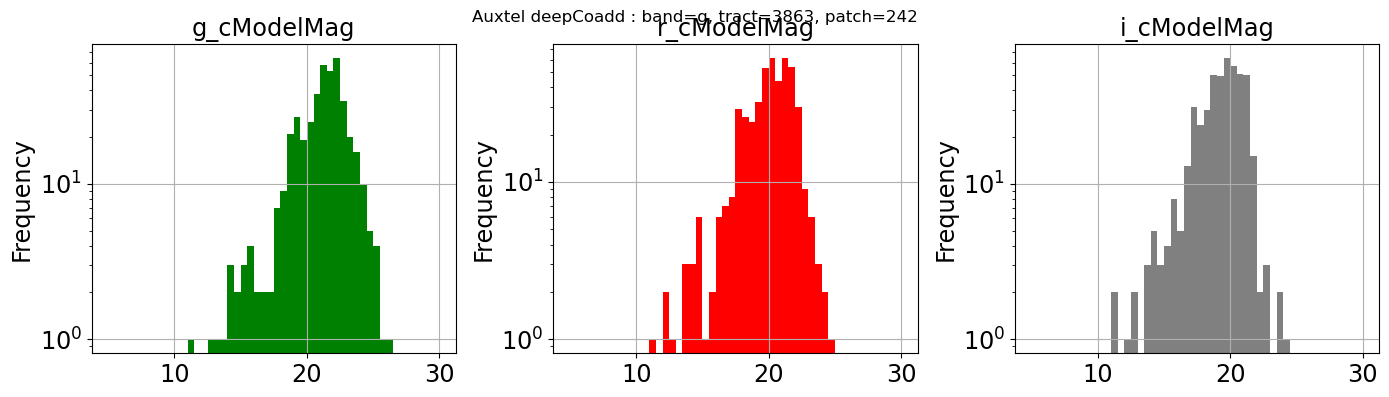

In [21]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

In [22]:
selection4 = df_sel["r_cModelMag"] < 15.0
df_sel = df_sel[selection4]

Text(0.5, 0.98, 'Auxtel deepCoadd : band=g, tract=3863, patch=242')

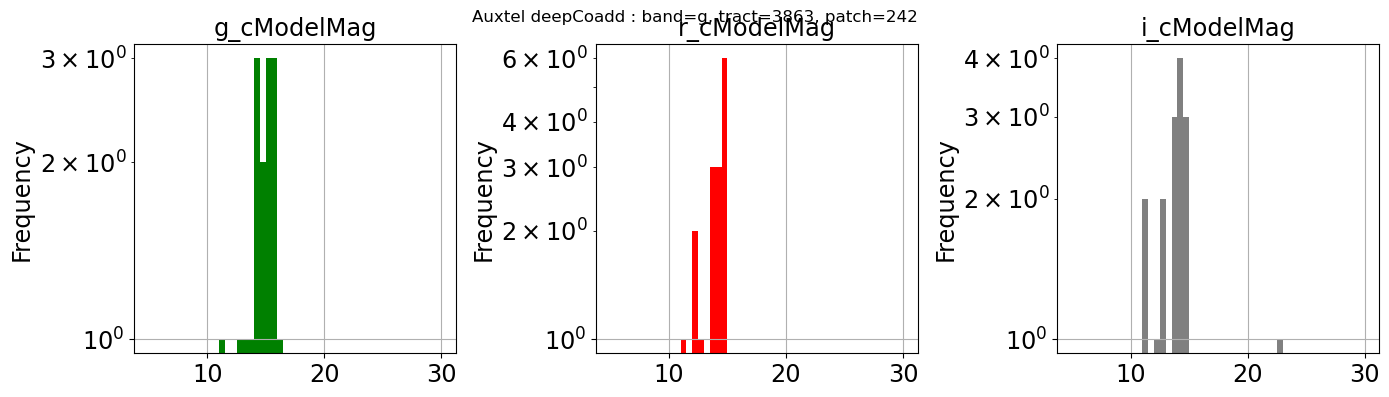

In [34]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4))

df_sel['g_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="g",logy=True,grid=True,title="g_cModelMag",ax=ax1)
df_sel['r_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="r",logy=True,grid=True,title="r_cModelMag",ax=ax2)
df_sel['i_cModelMag'].plot(kind="hist",bins=50,range=(5,30),facecolor="grey",logy=True,grid=True,title="i_cModelMag",ax=ax3)
plt.tight_layout()
plt.suptitle(the_title)

## Position

In [35]:
#colnames = list(df_sel.columns)
#for col in colnames:
    if "ra" in col:
        print(col)

coord_raErr
coord_ra
detect_isTractInner
coord_ra_dec_Cov
tract
i_ra
i_raErr
i_ra_dec_Cov
i_dataCoverage
i_pixelFlags_saturated
i_pixelFlags_saturatedCenter
i_kronFlux_flag_bad_radius
i_kronFlux_flag_no_fallback_radius
i_kronFlux_flag_no_minimum_radius
i_kronFlux_flag_small_radius
i_kronFlux_flag_used_minimum_radius
i_kronFlux_flag_used_psf_radius
g_ra
g_raErr
g_ra_dec_Cov
g_dataCoverage
g_pixelFlags_saturated
g_pixelFlags_saturatedCenter
g_kronFlux_flag_bad_radius
g_kronFlux_flag_no_fallback_radius
g_kronFlux_flag_no_minimum_radius
g_kronFlux_flag_small_radius
g_kronFlux_flag_used_minimum_radius
g_kronFlux_flag_used_psf_radius
r_ra
r_raErr
r_ra_dec_Cov
r_dataCoverage
r_pixelFlags_saturated
r_pixelFlags_saturatedCenter
r_kronFlux_flag_bad_radius
r_kronFlux_flag_no_fallback_radius
r_kronFlux_flag_no_minimum_radius
r_kronFlux_flag_small_radius
r_kronFlux_flag_used_minimum_radius
r_kronFlux_flag_used_psf_radius


In [36]:
pos_obj = df_sel[["x","y","g_ra","r_ra","i_ra", "g_dec","r_dec","i_dec" ]]
pos_obj

,x,y,g_ra,r_ra,i_ra,g_dec,r_dec,i_dec
objectId,,,,,,,,
1533582325747548433,43689.290972,36986.594583,120.086195,120.086193,120.086194,-36.209376,-36.209377,-36.209378
1533582325747550130,42292.131159,36230.587691,120.134165,120.134165,120.134163,-36.230576,-36.230577,-36.230577
1533582325747550236,44144.816403,36169.818771,120.070354,120.070355,120.070356,-36.231998,-36.231997,-36.231996
1533582325747550257,42200.374444,36214.310602,120.137332,120.137320,120.137332,-36.231050,-36.231042,-36.231050
1533582325747550422,42483.070949,36456.628315,120.127626,120.127627,120.127627,-36.224272,-36.224272,-36.224272
1533582325747550589,44158.971596,37062.343779,120.070042,120.070041,120.070041,-36.207200,-36.207201,-36.207203
1533582325747550701,42752.141092,37587.304258,120.118564,120.118559,120.118560,-36.192828,-36.192829,-36.192829
1533582325747550723,43962.039507,37469.991368,120.076897,120.076896,120.076897,-36.195910,-36.195911,-36.195910
1533582325747550746,42162.215237,37413.172395,120.138837,120.138838,120.138835,-36.197745,-36.197748,-36.197747


## deepCoadd

In [25]:
my_deepCoadd = butler.get('deepCoadd', dataId=the_dataId,collections=my_collection)
my_deepCoadd_inputs = butler.get("deepCoadd.coaddInputs",the_dataId,collections=my_collection)   

In [26]:
my_deepCoadd_inputs.visits.asAstropy()

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,goodpix,weight,filter
,pix,pix,pix,pix,,,
int64,int32,int32,int32,int32,int32,float64,str32
2023110700578,41800,35800,45199,39199,11008067,0.08396704019755799,SDSSg_65mm~empty
2023110700591,41800,35800,45199,39199,11553405,0.08228646923676833,SDSSg_65mm~empty
2023110700594,41800,35800,45199,39199,11553401,0.08117084357253634,SDSSg_65mm~empty


## Compare object position with deepcoadds

(41799.5, 45199.5, 35799.5, 39199.5)

<Figure size 600x600 with 0 Axes>

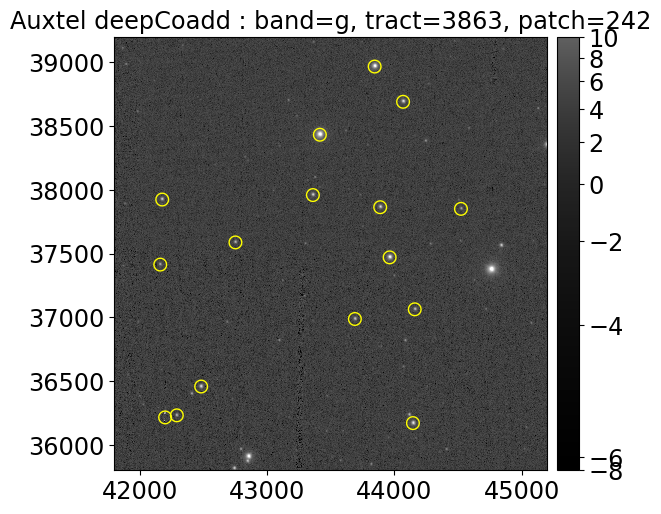

In [32]:
# Plot the calexp we just retrieved
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image,title=the_title )

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')

plt.gca().axis('on')

#plt.scatter(pos_obj.x.values,pos_obj.y.values,marker="o",color="y")

(41799.5, 45199.5, 35799.5, 39199.5)

<Figure size 1200x1200 with 0 Axes>

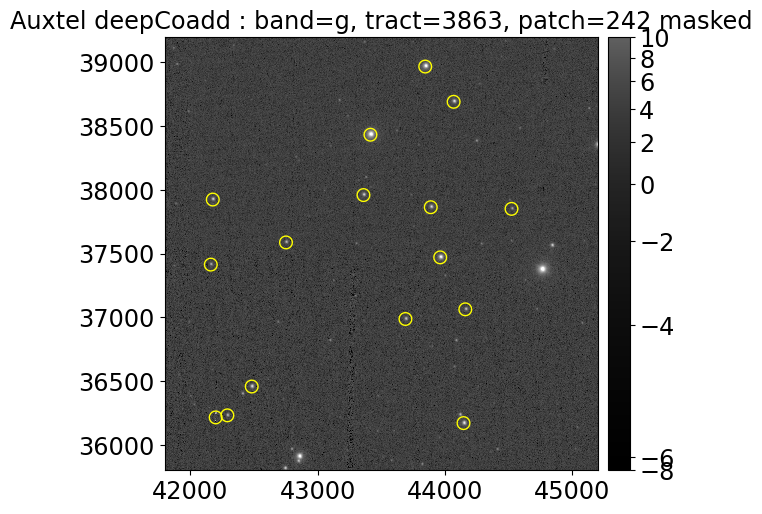

In [33]:
# Plot the calexp we just retrieved
plt.figure(figsize=(12,12))
afw_display = afwDisplay.Display(figsize=(12,12))
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.maskedImage.image,title=the_title+" masked")

with afw_display.Buffering():
    for index, row in pos_obj.iterrows():
        x = row["x"]
        y = row["y"]
        afw_display.dot('o', x , y, size=50, ctype='yellow')


plt.gca().axis('on')

## Histo

Text(0.5, 1.0, 'Auxtel deepCoadd : band=g, tract=3863, patch=242')

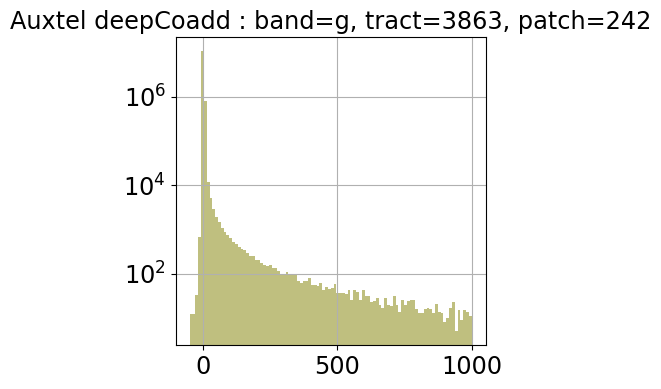

In [30]:
fig=plt.figure(figsize=(4,4))
ax=fig.add_subplot(1,1,1)
ax.hist(my_deepCoadd.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor='blue')
ax.hist(my_deepCoadd.maskedImage.image.array.flatten(),bins=100,range=(-50,1000),alpha=0.5,facecolor="yellow")
ax.set_yscale('log')
ax.grid()
ax.set_title(the_title)